In [1]:
# script for creating netcdf files ready for musa
import numpy as np
import pandas as pd
import xarray as xr

# system stuff
from glob import glob
import os
import sys
import socket
import datetime
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.warp
import pyproj
import glob
import rioxarray as rx

# import custom modules
if socket.gethostname() == 'ra':
    basepath = '/home/marcomaz/snowdepth/'
else :    
    basepath = '/uio/hypatia/geofag-felles/projects/snowdepth/'
    
mytoolspath = basepath + 'code/tools/own_repos/snowdepth/tools'
sys.path.append(mytoolspath)
wd = basepath+'marcomaz/Izas_op_2/'
#dempath = basepath+'data/MuSA_op/MuSA_input/DEM/DEM.nc'
#topopath = basepath+'data/Modeling/TopoSCALE/'
dempath = basepath+'data/Modeling/MuSA/DEM/Dem_full.nc'
dem = xr.open_dataset(dempath)

scd_path = basepath+'data/Theia/theia_download/SMD/'
files = glob.glob(scd_path+'*R2.tif')


### REPROJECT THE RASTERS

In [5]:
def reproject_raster(in_path:str, out_path:str, crs:str)-> str:


    """Function to reproject a raster to another crs and save the file in the input path
        in_path 
		out_path   
		crs (example: 'EPSG:25830');
		"""
	
    # reproject raster to project crs
    with rio.open(in_path) as src:
        src_crs = src.crs
        transform, width, height = rasterio.warp.calculate_default_transform(src_crs, crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()

        kwargs.update({
            'crs': crs,
            'transform': transform,
            'width': width,
            'height': height})

        with rio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                rasterio.warp.reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=crs,
                    resampling=rasterio.enums.Resampling.nearest)
					
    return(out_path)

In [6]:

for file in files:
    file_out = file[:-4]+'_reproj.tif'
    crsstr = 'EPSG:25830'
    reproject_raster(in_path=file, out_path=file_out, crs=crsstr)


## SLICE & RESAMPLE

In [2]:
files = glob.glob(scd_path+'*j.tif')

In [3]:
files

['/home/marcomaz/snowdepth/data/Theia/theia_download/SMD/MULTISAT_20210901-000000-000_L3B-SNOW_T30TYN_C_V1-0_SMD_R2_reproj.tif',
 '/home/marcomaz/snowdepth/data/Theia/theia_download/SMD/MULTISAT_20190901-000000-000_L3B-SNOW_T30TYN_C_V1-0_SMD_R2_reproj.tif',
 '/home/marcomaz/snowdepth/data/Theia/theia_download/SMD/MULTISAT_20180901-000000-000_L3B-SNOW_T30TYN_C_V1-0_SMD_R2_reproj.tif',
 '/home/marcomaz/snowdepth/data/Theia/theia_download/SMD/MULTISAT_20170901-000000-000_L3B-SNOW_T30TYN_C_V1-1_SMD_R2_reproj.tif',
 '/home/marcomaz/snowdepth/data/Theia/theia_download/SMD/MULTISAT_20200901-000000-000_L3B-SNOW_T30TYN_C_V1-0_SMD_R2_reproj.tif']

In [4]:
lista = []
for file in files[1:]:
    
    ds = rx.open_rasterio(file)
    xi,xf,yi,yf = dem.easting.min().values,dem.easting.max().values,dem.northing.min().values,dem.northing.max().values

    ds = ds.sel(x=slice(xi-20,xf),y=slice(yf,yi-20))
    ds = ds.rename({'y':'northing',
                    'x':'easting'})

    interp = ds.interp_like(dem,method='nearest',kwargs={"fill_value": "extrapolate"})

    lista.append(interp.drop('band').squeeze('band') \
                 .assign_coords(year=int(file.split('/')[-1] \
                 .split('_')[1][:4])+1) \
                 .expand_dims('year') \
                 .rename('SMD'))

In [5]:
SDC = xr.merge(lista)

In [6]:
SDC

<xarray.Dataset>
Dimensions:      (year: 4, northing: 211, easting: 457)
Coordinates:
  * year         (year) int64 2018 2019 2020 2021
    spatial_ref  int64 0
  * northing     (northing) float64 4.736e+06 4.736e+06 ... 4.732e+06 4.732e+06
  * easting      (easting) float64 7.056e+05 7.056e+05 ... 7.147e+05 7.147e+05
Data variables:
    SMD          (year, northing, easting) float64 0.0 0.0 0.0 ... 207.0 207.0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [7]:
SDC.to_netcdf(basepath+ 'data/Modeling/MuSA/MuSA_input_full/SMD.nc')

In [30]:
%matplotlib widget

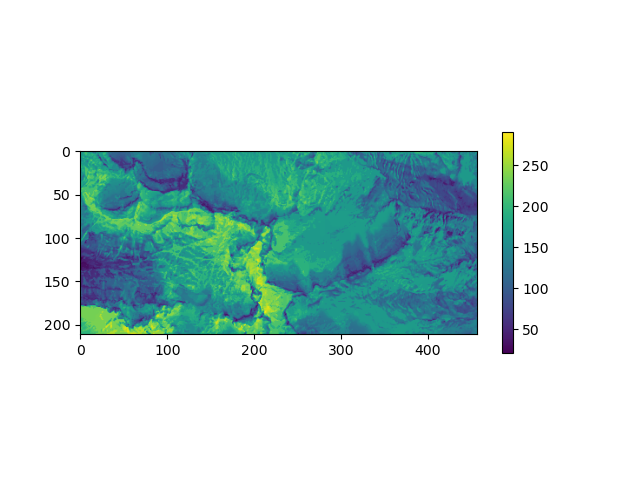

In [32]:
plt.figure()
plt.imshow(SDC.sel(year=2020).SCD.values)
plt.colorbar(shrink=0.6)

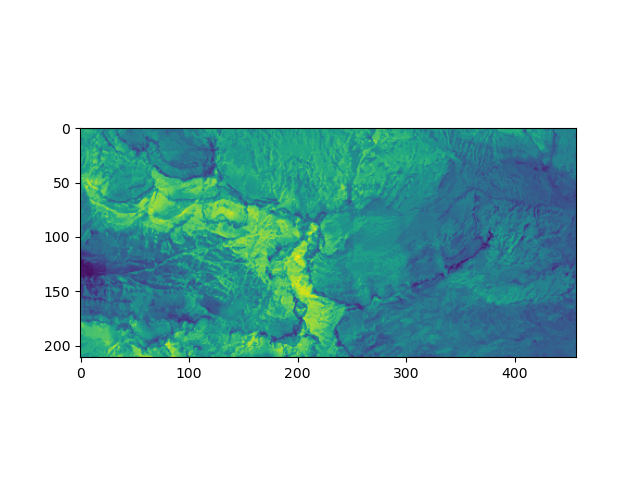

In [16]:
plt.figure()
plt.imshow(interp.values[0])

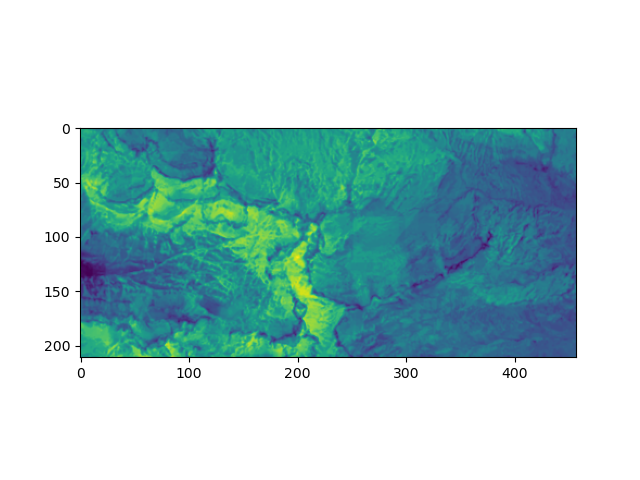

In [14]:
plt.figure()
plt.imshow(interp.values[0])